### 1. Data Setup

In [1]:
import os
import sys
import pylab
import caffe
import numpy
import matplotlib

+ Import related modules.

In [2]:
caffe_root='/Users/Vayne-Lover/Desktop/CS/Caffe/caffe'
sys.path.insert(0,caffe_root+'python')
os.chdir(caffe_root)
!data/mnist/get_mnist.sh
!examples/mnist/create_mnist.sh
os.chdir('examples/')

Downloading...
Creating lmdb...
I0821 15:17:29.840498 3332875200 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_train_lmdb
I0821 15:17:29.841820 3332875200 convert_mnist_data.cpp:88] A total of 60000 items.
I0821 15:17:29.841837 3332875200 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I0821 15:17:30.426640 3332875200 convert_mnist_data.cpp:108] Processed 60000 files.
I0821 15:17:30.457325 3332875200 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_test_lmdb
I0821 15:17:30.458592 3332875200 convert_mnist_data.cpp:88] A total of 10000 items.
I0821 15:17:30.458621 3332875200 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I0821 15:17:30.546733 3332875200 convert_mnist_data.cpp:108] Processed 10000 files.
Done.


+ Download data and change data to lmdb.

### 2. Net Setup

In [3]:
from caffe import layers as L
from caffe import params as P

def lenet(lmdb, batch_size):
    n = caffe.NetSpec()
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.fc1 =   L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()
    
with open('mnist/lenet_auto_train.prototxt', 'w') as f:
    f.write(str(lenet('mnist/mnist_train_lmdb', 64)))
    
with open('mnist/lenet_auto_test.prototxt', 'w') as f:
    f.write(str(lenet('mnist/mnist_test_lmdb', 100)))

+ Set up net with 2 convolution layers,2 pooling layers,2 inner product layers,a relu layer,a loss layer.

### 3. Running Setup

In [4]:
caffe.set_mode_cpu()
solver=None
solver=caffe.SGDSolver('mnist/lenet_auto_solver.prototxt')

+ Here i choose Stochastic Gradient Descent for solver.

#### 3.1 Details of Net

+ The details of net can be seen below.

In [5]:
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (64, 1, 28, 28)),
 ('label', (64,)),
 ('conv1', (64, 20, 24, 24)),
 ('pool1', (64, 20, 12, 12)),
 ('conv2', (64, 50, 8, 8)),
 ('pool2', (64, 50, 4, 4)),
 ('fc1', (64, 500)),
 ('score', (64, 10)),
 ('loss', ())]

#### 3.2 Details of Layers

In [6]:
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (20, 1, 5, 5)),
 ('conv2', (50, 20, 5, 5)),
 ('fc1', (500, 800)),
 ('score', (10, 500))]

### 4. Train Model

In [7]:
solver.net.forward()  
solver.test_nets[0].forward()

{'loss': array(2.432835340499878, dtype=float32)}

#### 4.1 Details of Data

+ The details of data can be seen below.

train labels: [ 5.  0.  4.  1.  9.  2.  1.  3.]


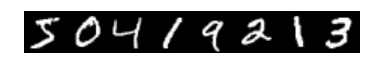

In [8]:
from pylab import *
%matplotlib inline
imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'train labels:', solver.net.blobs['label'].data[:8]

#### 4.2 Start Training

In [9]:
import numpy as np
import time
start=time.clock()
niter = 500  
test_interval = niter / 10
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
output = zeros((niter, 10, 10))
for it in range(niter):
    solver.step(1)  
    train_loss[it] = solver.net.blobs['loss'].data
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['score'].data[:10]
    
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4
end=time.clock()
print "LeNet Model cost: %f s" %(end-start)

Iteration 0 testing...
Iteration 50 testing...
Iteration 100 testing...
Iteration 150 testing...
Iteration 200 testing...
Iteration 250 testing...
Iteration 300 testing...
Iteration 350 testing...
Iteration 400 testing...
Iteration 450 testing...
LeNet Model cost: 143.229165 s


### 5. Test Model

#### 5.1 The accuracy of model

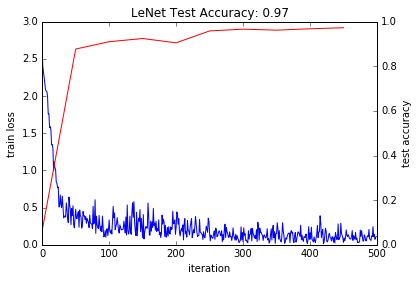

In [10]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('LeNet Test Accuracy: {:.2f}'.format(test_acc[-1]))

+ We can see that the accuracy is 0.97.

#### 5.2 Visual Predictions

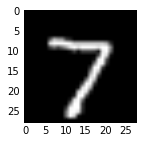

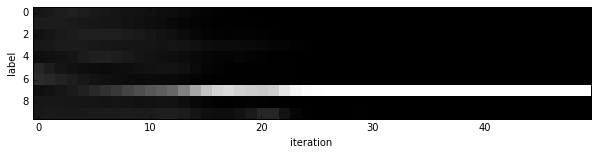

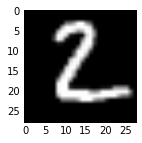

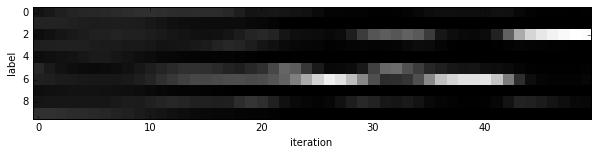

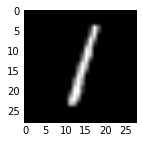

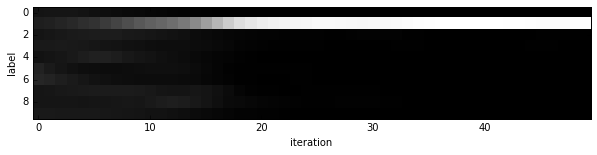

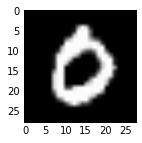

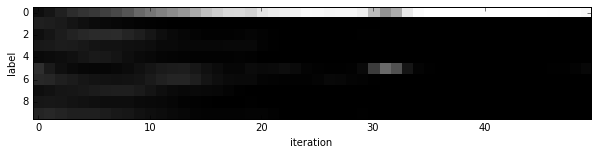

In [11]:
for i in range(4):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(exp(output[:50, i].T) / exp(output[:50, i].T).sum(0), interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')

### 6. Optimize Model

+ Here i will choose other parameters to optimize the model.

### 6.1 Adam

#### 6.1.1 Define Adam Model

In [12]:
train_net_path = 'mnist/custom_auto_train.prototxt'
test_net_path = 'mnist/custom_auto_test.prototxt'
solver_config_path = 'mnist/custom_auto_solver.prototxt'

def adam_net(lmdb, batch_size):
    n = caffe.NetSpec()
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.fc1 =   L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()

with open(train_net_path, 'w') as f:
    f.write(str(adam_net('mnist/mnist_train_lmdb', 64)))    
with open(test_net_path, 'w') as f:
    f.write(str(adam_net('mnist/mnist_test_lmdb', 100)))
    

from caffe.proto import caffe_pb2
s = caffe_pb2.SolverParameter()

s.random_seed = 0xCAFFE

s.train_net = train_net_path
s.test_net.append(test_net_path)
s.test_interval = 500  
s.test_iter.append(100) 

s.max_iter = 10000     

s.type = "Adam"
s.base_lr = 0.01  
s.momentum = 0.9
s.weight_decay = 5e-4

s.lr_policy = 'inv'
s.gamma = 0.0001
s.power = 0.75
s.display = 1000
s.snapshot = 5000
s.snapshot_prefix = 'mnist/custom_net'

# Train on the GPU
s.solver_mode = caffe_pb2.SolverParameter.CPU

with open(solver_config_path, 'w') as f:
    f.write(str(s))

solver = None  
solver = caffe.get_solver(solver_config_path)

#### 6.1.2 Train Adam Model

In [13]:
import time
start=time.clock()
niter = 500  
test_interval = niter / 10
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))

for it in range(niter):
    solver.step(1)  
    train_loss[it] = solver.net.blobs['loss'].data
    
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4
end=time.clock()
print "Adam Model cost: %f s" %(end-start)

Iteration 0 testing...
Iteration 50 testing...
Iteration 100 testing...
Iteration 150 testing...
Iteration 200 testing...
Iteration 250 testing...
Iteration 300 testing...
Iteration 350 testing...
Iteration 400 testing...
Iteration 450 testing...
Adam Model cost: 128.557408 s


#### 6.1.3 Test Adam Model

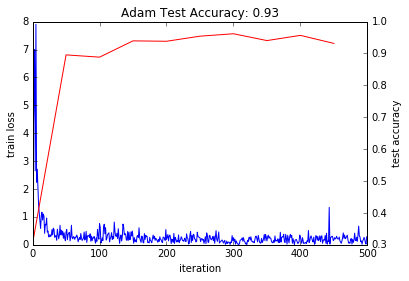

In [14]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Adam Test Accuracy: {:.2f}'.format(test_acc[-1]))

+ We can see that the accuracy is 0.93.

### 6.2 Nesterov

#### 6.2.1 Define Nesterov Model

In [15]:
train_net_path = 'mnist/custom_auto_train.prototxt'
test_net_path = 'mnist/custom_auto_test.prototxt'
solver_config_path = 'mnist/custom_auto_solver.prototxt'

def nesterov_net(lmdb, batch_size):
    n = caffe.NetSpec()
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.fc1 =   L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()

with open(train_net_path, 'w') as f:
    f.write(str(nesterov_net('mnist/mnist_train_lmdb', 64)))    
with open(test_net_path, 'w') as f:
    f.write(str(nesterov_net('mnist/mnist_test_lmdb', 100)))
    

from caffe.proto import caffe_pb2
s = caffe_pb2.SolverParameter()

s.random_seed = 0xCAFFE

s.train_net = train_net_path
s.test_net.append(test_net_path)
s.test_interval = 500  
s.test_iter.append(100) 

s.max_iter = 10000     

s.type = "Nesterov"
s.base_lr = 0.01  
s.momentum = 0.9
s.weight_decay = 5e-4

s.lr_policy = 'inv'
s.gamma = 0.0001
s.power = 0.75
s.display = 1000
s.snapshot = 5000
s.snapshot_prefix = 'mnist/custom_net'

s.solver_mode = caffe_pb2.SolverParameter.CPU

with open(solver_config_path, 'w') as f:
    f.write(str(s))

solver = None  
solver = caffe.get_solver(solver_config_path)

#### 6.2.2 Train Nesterov Model

In [16]:
import time
start=time.clock()
niter = 500  
test_interval = niter / 10
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))

for it in range(niter):
    solver.step(1)  
    train_loss[it] = solver.net.blobs['loss'].data
    
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4
end=time.clock()
print "Nesterov Model cost: %f s" %(end-start)

Iteration 0 testing...
Iteration 50 testing...
Iteration 100 testing...
Iteration 150 testing...
Iteration 200 testing...
Iteration 250 testing...
Iteration 300 testing...
Iteration 350 testing...
Iteration 400 testing...
Iteration 450 testing...
Nesterov Model cost: 103.876196 s


#### 6.2.3 Test Nesterov Model

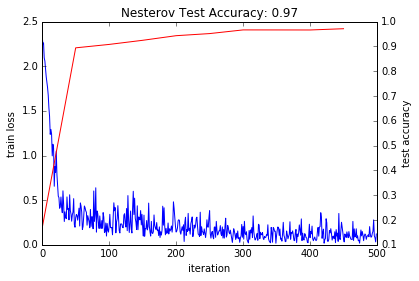

In [17]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Nesterov Test Accuracy: {:.2f}'.format(test_acc[-1]))

+ We can see that the accuracy is 0.97.

### 7. Comparision

+ After test all model,now i will choose the best model.

| Model         | Time           | Accuracy |
| :-----------: |:-------------:| :----:|
| LeNet      | 143.23 s | 97% |
| Adam      | 128.56 s      |   93% |
| Nesterov | 103.88 s      |    97% |

+ In my opinion,though the accuracy of Nesterov model and LeNet is both 97%,but LeNet costs more time.Therefore I will choose Nesterov for my final model. 